In [164]:
import pandas as pd
import numpy as np

# метрики
from sklearn.metrics import classification_report, \
roc_curve, roc_auc_score, precision_recall_curve, precision_score, f1_score, confusion_matrix, precision_score, recall_score,\
average_precision_score

# препроцесинг
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline,FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# модели
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.svm import SVC

from matplotlib import pyplot as plt

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score 

4. сделать выводы о том, какая модель справилась с задачей лучше других


In [165]:
df = pd.read_csv('train_case2.csv', delimiter=';')
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [166]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


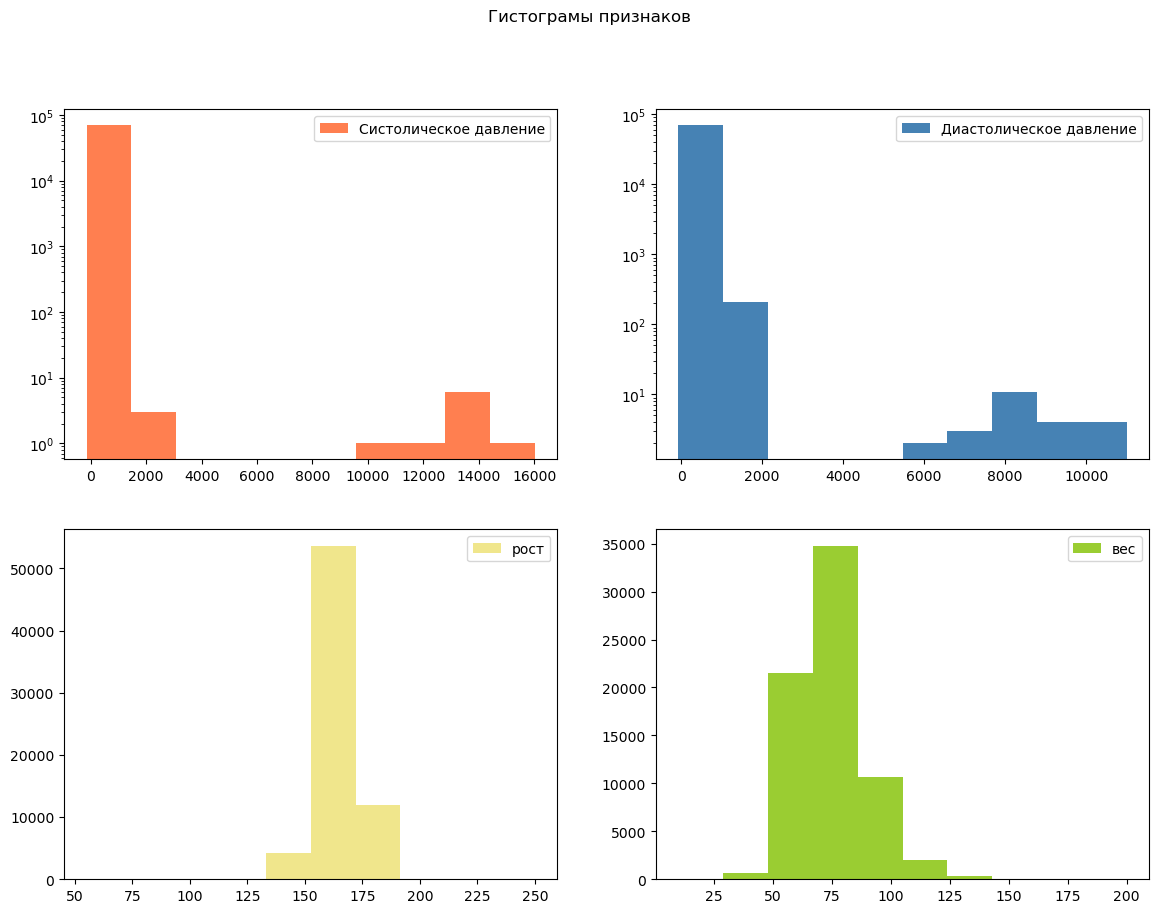

In [167]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Гистограмы признаков')
axs[0, 0].hist(df['ap_hi'], log=True, color='coral');
axs[0, 0].legend(['Систолическое давление'], fontsize=10)

axs[0, 1].hist(df['ap_lo'], log=True, color='steelblue'); 
axs[0, 1].legend(['Диастолическое давление'], fontsize=10)

axs[1, 0].hist(df['height'], color='khaki');
axs[1, 0].legend(['рост'], fontsize=10)
axs[1,1].hist(df['weight'], color='yellowgreen');
axs[1, 1].legend(['вес'], fontsize=10);

Признаки роста и веса в целом находятсяв допустимом диапазоне, признаки свяязаные с давлением имеют явные вбросы

#### Добавление признака IMT

Введем признак Imt как признак обобщающий соотношения веса и роста. IMT является показателем наличия избыточного веса в зависимости от роста и корелирует с целевой переменой cardio сильнее чем рост  и вес по отдельности. Признаки роста и веса отбросим как избыточные.

In [168]:
df['imt'] = df['weight']/(df['height']*10**(-2))**2
df.drop(columns=['height', 'weight'], inplace=True)

### Убераем Вбросы признаков связаных с давлением

В данных по давлению есть вбросы и некоректные значений например давление не может быть отрицательным и не может быть больше 1000. Скректируем их предполагая что данные были ошибочно занесены оператором например вместо 120 оператор указал 12000 и т.д и т.п. Рекорд по давлению, зафиксированный в мире, составляет 310/220 мм рт. ст. Это самое большое давление из когда-либо зафиксированных. Данные диапозаны возьмем как верхние границы возможных давлений.

In [169]:
col_for_replacement = ['ap_lo', 'ap_hi']
for col in col_for_replacement:
    dict_rep = {}
    for el in df[col]:
        if el < 0:
            dict_rep[el]=abs(el)
        elif el > 310 and el < 3000:
            dict_rep[el]= el/10
        elif el>3100:
            dict_rep[el]=el/100       
    df[col].replace(dict_rep, inplace=True)    
    
df = df.loc[(df['ap_hi']>50) & (df['ap_hi']<310)]
df = df.loc[(df['ap_lo']>40) & (df['ap_lo']<220)]

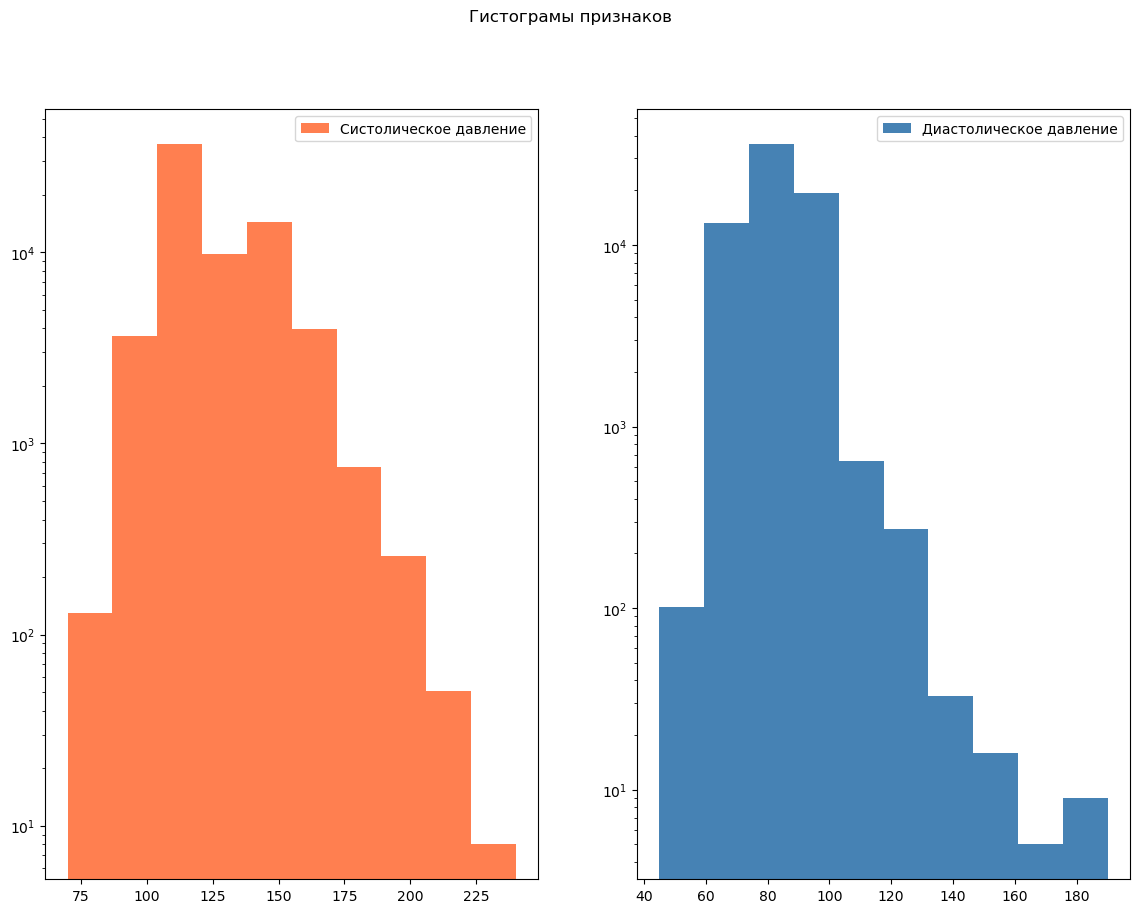

In [170]:
fig, axs = plt.subplots(1, 2, figsize=(14, 10))
fig.suptitle('Гистограмы признаков')
axs[0].hist(df['ap_hi'], log=True, color='coral');
axs[0].legend(['Систолическое давление'], fontsize=10)

axs[1].hist(df['ap_lo'], log=True, color='steelblue'); 
axs[1].legend(['Диастолическое давление'], fontsize=10);

In [199]:
df.drop(columns=['id'], inplace=True)

### Функция для расчета метрик моделей

In [171]:
 def metrics(y, y_preds, y_score, model, X_train, y_train):
    metric_dict = {}
    precision, recall, thresholds = precision_recall_curve(y, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    metric_dict['F-Score'] = fscore[ix]
    metric_dict['precision'] = precision[ix]
    metric_dict['recall'] = recall[ix]
    metric_dict['thresholds'] = thresholds[ix]
    
    metric_dict['roc_auc_score'] = roc_auc_score(y, y_preds)
    metric_dict['pr_score'] = average_precision_score(y, y_preds)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    metric_dict['CV'] = f'CV score is {cv_score}+-{cv_score_std}'      
    
    return metric_dict

In [172]:
def metrics_for_bs(y, y_score):
    
    bs_dict={}
    rubl_test = 1400
    rubl_early_treatment = 15000
    rubl_late_treatment = 20000
    
    b = 1
    precision, recall, thresholds = precision_recall_curve(y, y_score)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    cnf_matrix = confusion_matrix(y, y_score > thresholds[ix])
    
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP / (TP+FN)
    FPR = FP / (FP+TN)
    TNR = TN / (FP+TN)
    
    rubl_1 = (FN + TP) * rubl_late_treatment
    rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
    rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
    
    bs_dict['расходы, если не делать тест и ждать симптомов:'] = rubl_1
    bs_dict['расходы, если делать тест всем и лечить группу большых:'] = rubl_test_all
    bs_dict['расходы, если использовать МЛ:']=rubl_ML
    return bs_dict

#### Piplines

In [173]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    # Декодирунт категориальные признаки
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


### Функция для сборки пайплайна 

In [174]:
continuos_cols = ['age', 'ap_hi', 'ap_lo', 'imt']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

def pipline_constructor(continuos_cols, cat_cols, base_cols, standartization=None):
    """Функция сборки пайплайна для различных видов стандартизации числовых данных"""

    continuos_transformers = []
    cat_transformers = []
    base_transformers = []
    
    # непрерывные величины
    if standartization == 'MinMaxScaler': 
        for cont_col in continuos_cols:
            transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', MinMaxScaler())])
            continuos_transformers.append((cont_col, transfomer))
    elif standartization == 'StandardScaler':
        for cont_col in continuos_cols:
            transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
                ])
            continuos_transformers.append((cont_col, transfomer))
               
    else:
        for cont_col in continuos_cols:
            transfomer =  Pipeline([
                    ('selector', NumberSelector(key=cont_col))])
            continuos_transformers.append((cont_col, transfomer))

    # категориальные величины
    for cat_col in cat_cols:
        cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
        cat_transformers.append((cat_col, cat_transformer))

    # категориальные величины с 2 мя категориями
    for base_col in base_cols:
        base_transformer = Pipeline([
                    ('selector', NumberSelector(key=base_col))
            ])
        base_transformers.append((base_col, base_transformer))
        
        
    feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

    return feats



### Логистическая регресия

In [207]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=14)

feats = pipline_constructor(continuos_cols, cat_cols, base_cols, standartization='StandardScaler')
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

array([[ 1.64770022, -0.40801699, -0.16749498, ...,  1.        ,
         0.        ,  1.        ],
       [-0.26290783,  0.175106  , -1.27589453, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.12140057, -0.40801699, -0.16749498, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.87966409,  0.75822899,  0.84014097, ...,  0.        ,
         0.        ,  0.        ],
       [-1.3615682 ,  0.175106  , -0.16749498, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.9863982 , -0.40801699, -0.16749498, ...,  0.        ,
         0.        ,  0.        ]])

In [208]:
X_train

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,imt
8888,23539,2,120.0,80.0,1,3,1,0,1,22.129740
59567,18821,1,130.0,69.0,1,1,0,0,1,37.253645
27860,19770,1,120.0,80.0,1,1,0,0,1,35.755956
45172,23263,1,110.0,70.0,1,1,0,0,1,28.548281
35997,20296,1,150.0,100.0,1,1,0,0,1,23.140496
...,...,...,...,...,...,...,...,...,...,...
39630,19596,1,120.0,80.0,1,1,0,0,1,23.875115
56168,21242,1,120.0,80.0,2,1,0,0,1,23.999459
44961,17298,1,140.0,90.0,1,1,0,0,0,24.977043
22941,16108,1,130.0,80.0,1,1,0,0,1,36.310821


In [201]:
log_reg = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])

# обучим пайплайн на всем тренировочном датасете
log_reg.fit(X_train, y_train)
y_score = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)
log_dict = metrics(y_test, y_pred, y_score, log_reg, X_train, y_train)
log_dict_bs=metrics_for_bs(y_test, y_score)

### CATBOOST

Catboost имеет свои внутрение методы для работы с категориальными, числовыми и текстовыми признаками поэтому пайплайн тут не понадобится

In [209]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=14)


In [212]:
cat = CatBoostClassifier(n_estimators=100, max_depth=3,
                                      silent=True, random_state=42)


# обучим пайплайн на всем тренировочном датасете
cat.fit(X_train, y_train)
y_score = cat.predict_proba(X_test)[:, 1]
y_pred = cat.predict(X_test)

cat_dict = metrics(y_test, y_pred, y_score, cat, X_train, y_train)
cat_dict_bs = metrics_for_bs(y_test, y_score)

### Случайный лес

In [213]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=42)

feats = pipline_constructor(continuos_cols, cat_cols, base_cols, standartization=None)
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

array([[1.5922e+04, 1.3000e+02, 9.0000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.9616e+04, 1.1000e+02, 7.0000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [2.1064e+04, 1.4000e+02, 9.0000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       ...,
       [1.5497e+04, 1.2000e+02, 8.0000e+01, ..., 1.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.5961e+04, 1.2000e+02, 8.0000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [2.0326e+04, 1.5000e+02, 8.0000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]])

In [214]:
forest = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=140, max_depth=7, )),
])


# обучим пайплайн на всем тренировочном датасете
forest.fit(X_train, y_train)
y_score = forest.predict_proba(X_test)[:, 1]
y_pred = forest.predict(X_test)
forest_dict = metrics(y_test, y_pred, y_score, forest, X_train, y_train)
forest_dict_bs=metrics_for_bs(y_test, y_score)

### Метрики по 3м моделям

In [215]:
metrics_df = pd.DataFrame(log_dict.values(), index=log_dict.keys(), columns=['log_reg'])
metrics_df.insert(loc=len(metrics_df.columns), column='catboost', value=cat_dict.values())
metrics_df.insert(loc=len(metrics_df.columns), column='forest', value=forest_dict.values())
metrics_df

,log_reg,catboost,forest
F-Score,0.741189,0.748479,0.745601
precision,0.701453,0.70054,0.685632
recall,0.785698,0.803461,0.817065
thresholds,0.418276,0.388219,0.382941
roc_auc_score,0.732515,0.739268,0.733155
pr_score,0.677651,0.682331,0.6831
CV,CV score is 0.7909800083418507+-0.005415063286...,CV score is 0.8005741878474539+-0.005188858686...,CV score is 0.7987561282511754+-0.007176817840...


Чуть лучшей метрикой F score обладает catboost

3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
    - стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - стоимость теста 1400р

### Бизнес метрики по стоимости

In [216]:
metrics_df_bs = pd.DataFrame(log_dict_bs.values(), index=log_dict_bs.keys(), columns=['log_reg'])
metrics_df_bs.insert(loc=len(metrics_df_bs.columns), column='catboost', value=cat_dict_bs.values())
metrics_df_bs.insert(loc=len(metrics_df_bs.columns), column='forest', value=forest_dict_bs.values())
metrics_df_bs

,log_reg,catboost,forest
"расходы, если не делать тест и ждать симптомов:",174520000,174520000,175800000
"расходы, если делать тест всем и лечить группу большых:",155301800,155301800,156261800
"расходы, если использовать МЛ:",153927200,153479800,154558600


In [217]:
print(f'экономия при использованиеи catboost vs log_reg {153927200 - 153371200}\n\
экономия при использованиеи catboost vs forest {153500200 - 153371200}')

экономия при использованиеи catboost vs log_reg 556000
экономия при использованиеи catboost vs forest 129000


catboost также экономит чуть больше денег на анализах


5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ответ

В проблеме дисбаланса категории кривая ROC обычно дает более оптимистическую оценку эффекта, поэтому кривая PR лучше при дисбалансе классов
ROC кривая строится в отношении TPR=TP/(TP+FN) vs FPR = FP/(FP+TN) в зависимости от порога вероятности

Уровень ложноположительных результатов FPR для сильно несбалансированных наборов данных снижается из-за большого количества истинно отрицательных результатов (TN растет когда у нас мало элементов отрицательного класса)

Кривая PRС TPR vs recall (TP/(TP+FP)) не так чувствительна к дисбалансу классов 
PRC определяется соотношением позитивов (P) и негативов (N) как y = P/(P + N). для несбалансированного распределения классов, в котором соотношение P:N составляет 1:10. При этом линиия PCR также меняется в зависимости от соотношения P:N.